In [1]:
%pylab inline
from qutip import *
import numpy as np


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(2, 60)
2
{'d2wdt2': 1.0000000000000001e+43, 'envelope': 0, 'dwdt': 1e+47}


In [16]:
#Defining time scales
total_time = 100
steps = 3000
state_transfer = True
RWA = True
RFT = True
time_list = np.linspace(0,total_time, steps)

#Defining H0





qubit_state_num = 3

fq= 4.6/(2*np.pi)
kappa = 0.05
gamma = 0.001
g = 0.05

mode_state_num = 30
#g = 2.*np.pi*0.1 #GHz
fc = 5.0/(2*np.pi) #GHz
state_num = qubit_state_num * mode_state_num
if RFT:
    fq = fq-fc
    fc = 0
    
wc = 2*np.pi*fc
wa = 2*np.pi*fq


alpha = 0.224574
ens = np.array([ 2*np.pi*ii*(fq - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0q = np.kron(np.identity(mode_state_num),np.diag(ens))

a   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),1),np.identity(qubit_state_num))
adag   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),-1),np.identity(qubit_state_num))
sm = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),1))
smdag = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))

if RWA:
     H0 = wc * np.dot(adag,a) + H0q + g * (np.dot(adag,sm) + np.dot(a,smdag))
else:
     H0 = wc * np.dot(adag,a) + H0q +  g * np.dot((adag + a),(sm + smdag))
#Defining Forbidden sates


#Defining Concerned states (starting states)
psi0=[0,1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g0','e0','g1']




#Defining U (Target)
if state_transfer:
    U =[]
    U1 = np.zeros(state_num,dtype=complex)
    U1[1]=1
    U1[0]=0
    U.append(U1)
    U2 = np.zeros(state_num,dtype=complex)
    U2[0]=1
    U.append(U2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

print np.shape(U)
#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
IX = a + adag
IY = (0+1j)* (a-adag)
Hops = [IX]
ops_max_amp = [0.1]
Hnames =['HI']

#Defining convergence parameters
max_iterations = 500
decay = max_iterations/2
convergence = {'rate':0.05, 'update_step':1, 'max_iterations':max_iterations,\
               'conv_target':1e-10,'learning_rate_decay':decay}
reg_coeffs = {'envelope' : 0,  'dwdt':0.001*10**50,'d2wdt2':0.001*0.0001*10**50}
#, 'forbidden':100 , 'states_forbidden_list': [3]
#reg_coeffs = { 'speed_up':100}
#reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              #'f':freq_ge, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':True, 'Modulation':True}

    #Defining initial pulses

print len(U)
print reg_coeffs

H0 = Qobj(H0)
HI = Qobj(IX)
e0 = basis(qubit_state_num*mode_state_num, 1) 
g0 = basis(qubit_state_num*mode_state_num, 0) 
f0 = basis(qubit_state_num*mode_state_num, 2) 
HQ = Qobj(IY)
a = Qobj(a)
sm = Qobj(sm)
c_ops = []
c_ops.append(np.sqrt(kappa)*a)
c_ops.append(np.sqrt(gamma)*sm)

(2, 90)
2
{'d2wdt2': 1.0000000000000001e+43, 'envelope': 0, 'dwdt': 1e+47}


In [4]:
chi = g*g/(wc - wa)
print chi/kappa
print kappa,gamma

0.125
0.05 0.001


In [17]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 2

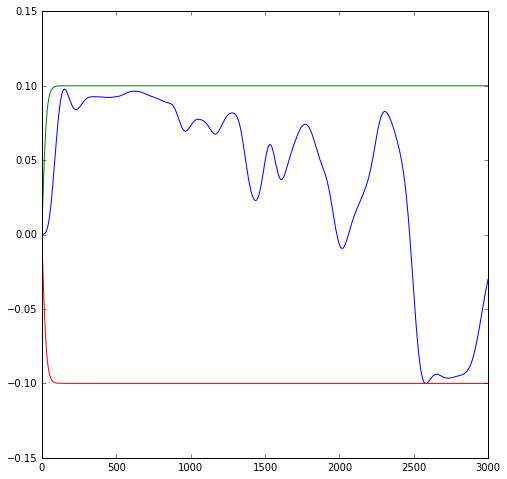

In [18]:
import h5py
u0=[]
with h5py.File('/home/mohamed/Data2/00072_JC.h5','r') as hf:
    intr = np.array(hf.get('uks'))[-1]
    f = 0.96*butter_lowpass_filter(np.array(hf.get('uks'))[-1],cutoff,fs)
    #u0.append(np.concatenate([np.interp(np.linspace(0,total_time/2, steps/3),np.linspace(0,total_time, len(intr[0])),intr[0]),np.zeros(2*steps/3)]))
    u0.append(np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(f[0])),f[0]))


plot(u0[0])
plot(0.1*np.tanh(np.linspace(0,total_time, steps)/1.))
plot(-0.1*np.tanh(np.linspace(0,total_time, steps)/1.))

#u0 = []
#u0.append(0.1*np.sin(0.031*np.linspace(0,total_time, steps)))
#plot(u0[0])

In [19]:
args ={}
print RFT
args['wc'] = wc
dt = float(total_time)/steps
if RFT:
    Isignal = "0.1*tanh(t/10.)"
else:
    Isignal = "0.1*tanh(t/10.)*cos(wc*t)"
H = [H0, [HI, Isignal]]
def H1_coeff(t, args):
    idx = int(t/dt)
    if idx >= len (u0[0]):
        idx = len (u0[0]) -1
   
    return u0[0][idx]
#H = [H0,[HI,H1_coeff]]
#H = H0
#g_output = mcsolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=5000, options=Options(nsteps=15), args = args)
g_output = mesolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm],  options=Options(nsteps=150), args = args)
e_output = mesolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm],  options=Options(nsteps=150), args= args)
#f_output = mesolve(H, f0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm],  options=Options(nsteps=150), args= args)
#e_output = mcsolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=5000, options=Options(nsteps=15), args= args)

H = [H0,[HI,H1_coeff]]
g_output_o = mesolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm],  options=Options(nsteps=150), args = args)
e_output_o = mesolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm],  options=Options(nsteps=150), args= args)



True


In [7]:
np.save("e_1000_traj", e_output.expect)
np.save("g_1000_traj", g_output.expect)

In [7]:
def Rotate (I, Q, theta):
    return I *cos (theta) + Q* sin (theta), -I* sin (theta) + Q *cos (theta)


24.3425127867 -27.7793886295


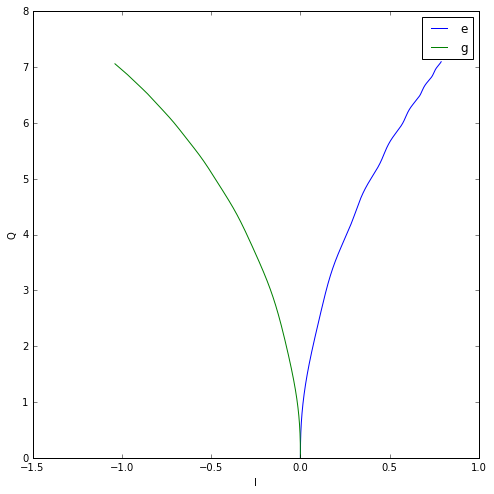

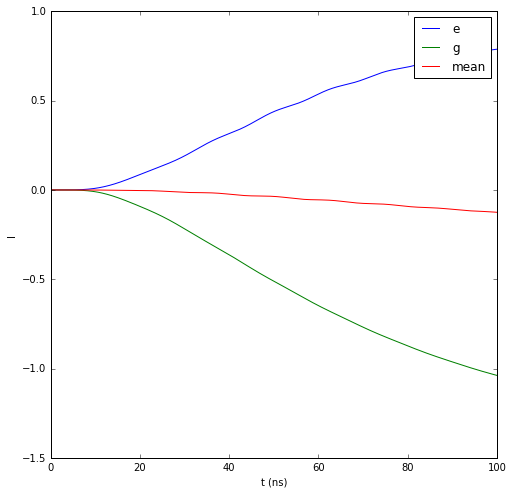

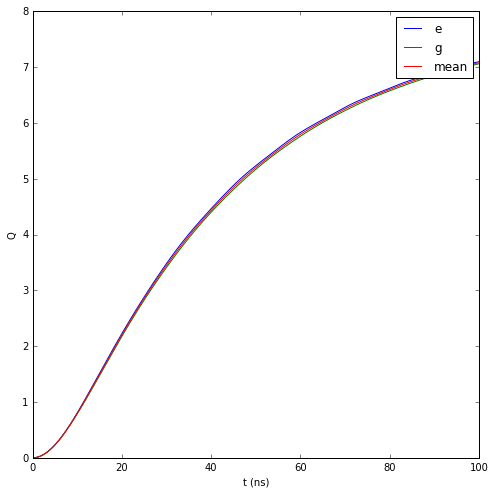

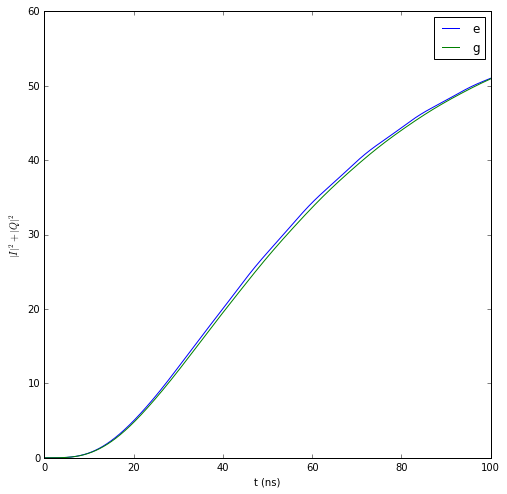

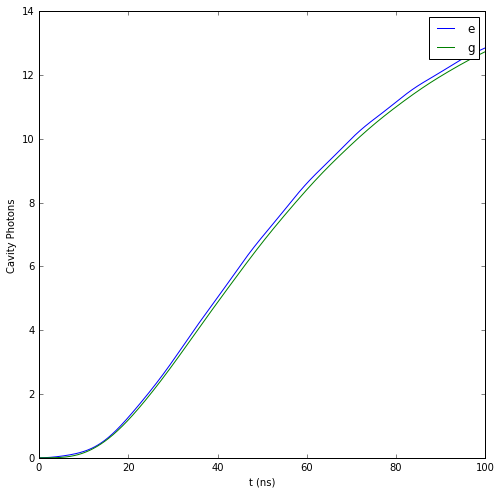

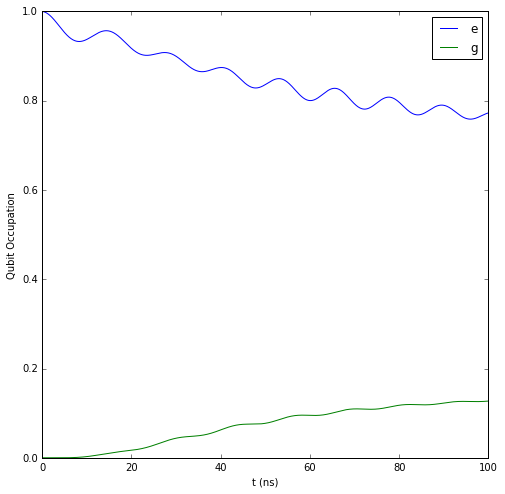

In [14]:
Ie = e_output.expect[0]
Ig = g_output.expect[0]
Qe = e_output.expect[1]
Qg = g_output.expect[1]




if not RFT:
    Ie, Qe = Rotate (Ie, Qe, wc*time_list)
    Ig, Qg = Rotate (Ig, Qg, wc*time_list)

Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)
figsize(8,8)

figure()
plot (Ie,Qe, label ="e")
plot (Ig,Qg, label = "g")
ylabel ("Q")
xlabel("I")
legend()

figure()
plot (time_list,Ie, label="e")
plot (time_list,Ig, label = "g")
plot (time_list, Imid, label = "mean")
xlabel('t (ns)')
ylabel('I')
legend()
np.save("I1",Ie)
np.save("I0",Ig)
print np.sum(Ie[:len(Ie)/2])/10.0,np.sum(Ig[:len(Ie)/2])/10.0

figure()
plot (time_list,Qe, label= "e")
plot (time_list,Qg, label = "g")
plot (time_list, Qmid, label = "mean")
xlabel('t (ns)')
ylabel('Q')
legend()

figure()
plot (time_list,np.square(np.abs(Qe)) + np.square(np.abs(Ie)), label = "e")
plot (time_list,np.square(np.abs(Qg)) + np.square(np.abs(Ig)), label ="g")
xlabel('t (ns)')
ylabel('$|I|^2 + |Q|^2$')
legend()

figure()
plot ( time_list, e_output.expect[2], label ="e")
plot ( time_list, g_output.expect[2], label = "g")
xlabel('t (ns)')
legend()

ylabel('Cavity Photons')
np.save("photons1",e_output.expect[2])
np.save("photons0",g_output.expect[2])

np.save("tlist",time_list)
figure()
plot (time_list, e_output.expect[3], label = "e")
plot ( time_list, g_output.expect[3], label = "g")

xlabel('t (ns)')
np.save("qubit1",e_output.expect[3])
np.save("qubit0",g_output.expect[3])

legend()
ylabel('Qubit Occupation')



12.3070587257 -28.4728086088
13.7927391587 -31.4948667463


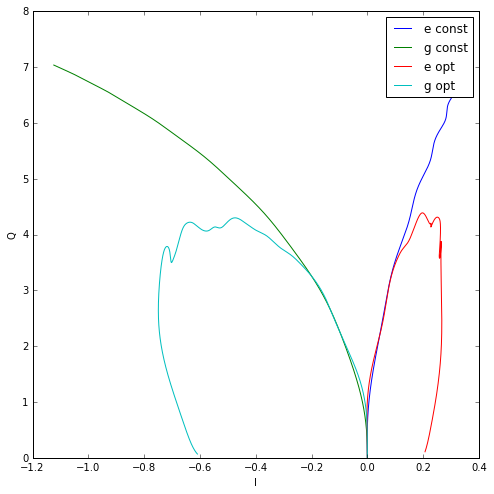

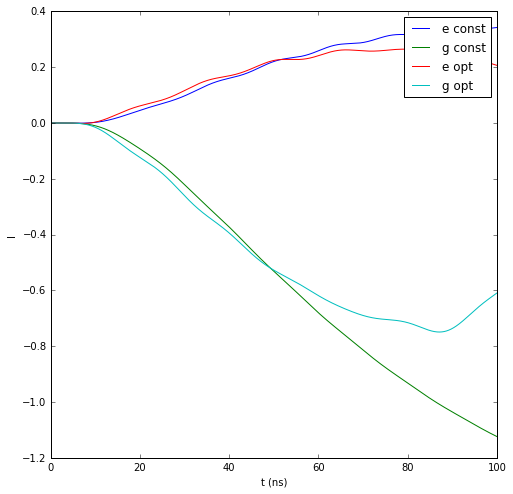

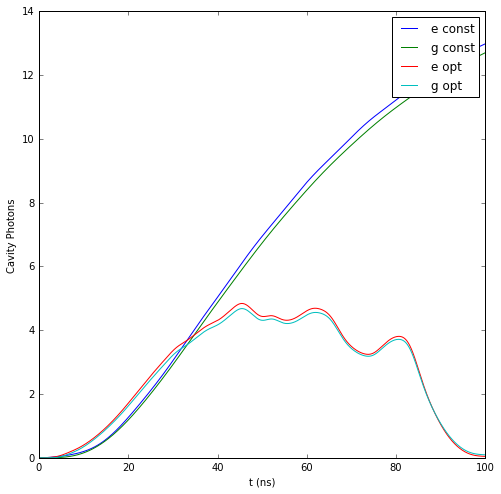

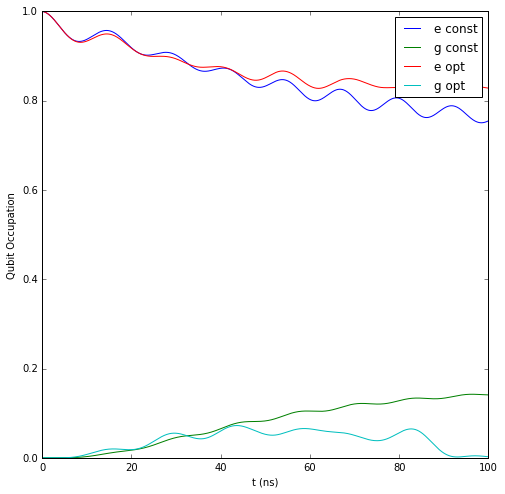

In [20]:
Ie = e_output.expect[0]
Ig = g_output.expect[0]
Qe = e_output.expect[1]
Qg = g_output.expect[1]

Ie2 = e_output_o.expect[0]
Ig2 = g_output_o.expect[0]
Qe2 = e_output_o.expect[1]
Qg2 = g_output_o.expect[1]


if not RFT:
    Ie, Qe = Rotate (Ie, Qe, wc*time_list)
    Ig, Qg = Rotate (Ig, Qg, wc*time_list)

    Ie2, Qe2 = Rotate (Ie2, Qe2, wc*time_list)
    Ig2, Qg2 = Rotate (Ig2, Qg2, wc*time_list)
    
    
Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)

Imid2 = 0.5*(Ie2 + Ig2)
Qmid2 = 0.5*(Qe2 + Qg2)
Idiff2 = np.abs(Ie2-Ig2)
Qdiff2 = np.abs(Qe2 - Qg2)

figsize(8,8)

figure()
plot (Ie,Qe, label ="e const")
plot (Ig,Qg, label = "g const")
plot (Ie2,Qe2, label ="e opt")
plot (Ig2,Qg2, label = "g opt")
ylabel ("Q")
xlabel("I")
legend()

figure()
plot (time_list,Ie, label="e const")
plot (time_list,Ig, label = "g const")
plot (time_list,Ie2, label="e opt")
plot (time_list,Ig2, label = "g opt")

xlabel('t (ns)')
ylabel('I')
legend()
np.save("I1",Ie)
np.save("I0",Ig)
print np.sum(Ie[:len(Ie)/2])/10.0,np.sum(Ig[:len(Ie)/2])/10.0
print np.sum(Ie2[:len(Ie)/2])/10.0,np.sum(Ig2[:len(Ie)/2])/10.0



figure()
plot ( time_list, e_output.expect[2], label ="e const")
plot ( time_list, g_output.expect[2], label = "g const")
plot ( time_list, e_output_o.expect[2], label ="e opt")
plot ( time_list, g_output_o.expect[2], label = "g opt")
xlabel('t (ns)')
legend()

ylabel('Cavity Photons')
np.save("c_photons1",e_output.expect[2])
np.save("c_photons0",g_output.expect[2])
np.save("o_photons1",e_output_o.expect[2])
np.save("o_photons0",g_output_o.expect[2])

np.save("tlist",time_list)
figure()
plot (time_list, e_output.expect[3], label = "e const")
plot ( time_list, g_output.expect[3], label = "g const")
plot (time_list, e_output_o.expect[3], label = "e opt")
plot ( time_list, g_output_o.expect[3], label = "g opt")
xlabel('t (ns)')
np.save("c_qubit1",e_output.expect[3])
np.save("c_qubit0",g_output.expect[3])
np.save("o_qubit1",e_output_o.expect[3])
np.save("o_qubit0",g_output_o.expect[3])
legend()
ylabel('Qubit Occupation')



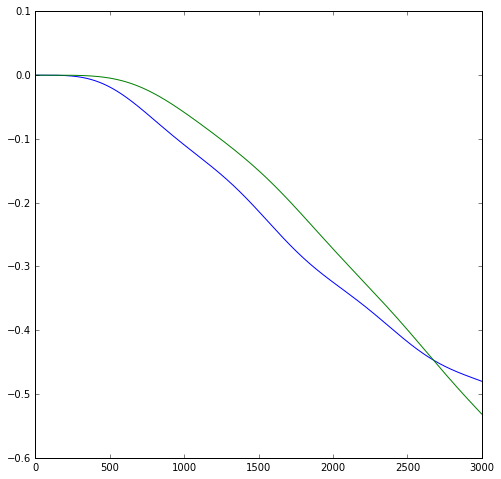

In [171]:
plot(Ig[:int(r*len(Ie))])
plot(Ig1[:int(r*len(Ie))])

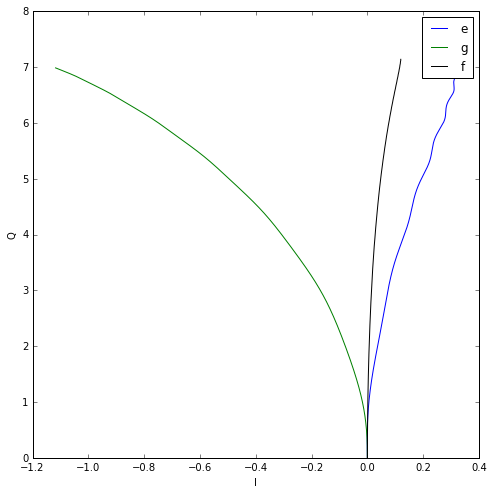

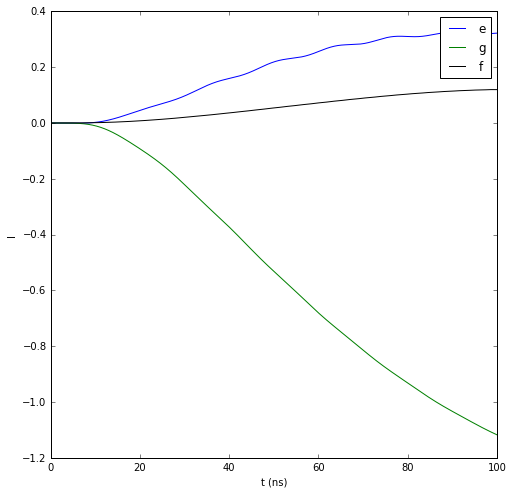

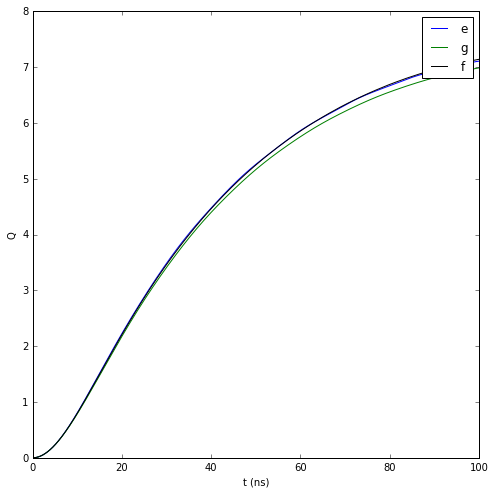

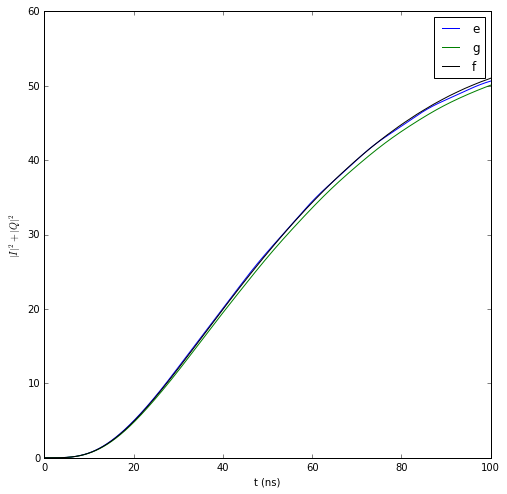

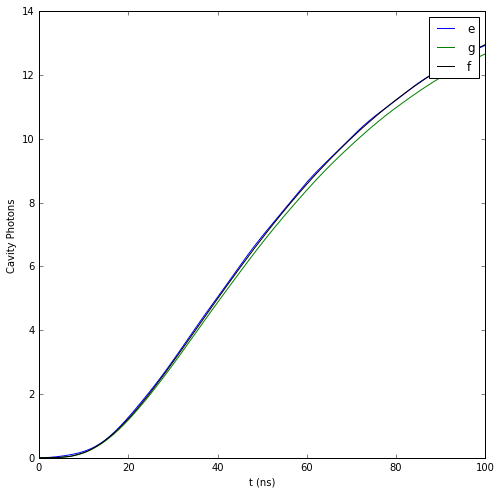

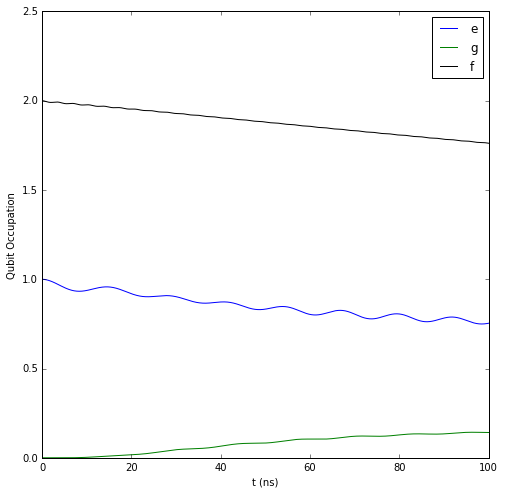

In [22]:
Ie = e_output.expect[0]
Ig = g_output.expect[0]
Qe = e_output.expect[1]
Qg = g_output.expect[1]
If = f_output.expect[0]
Qf = f_output.expect[1]



if not RFT:
    Ie, Qe = Rotate (Ie, Qe, wc*time_list)
    Ig, Qg = Rotate (Ig, Qg, wc*time_list)
    If, Qf = Rotate (If, Qf, wc*time_list)

Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)
figsize(8,8)

figure()
plot (Ie,Qe, label ="e")
plot (Ig,Qg, label = "g")
plot (If,Qf, label = "f",color ='k')

ylabel ("Q")
xlabel("I")
legend()

figure()
plot (time_list,Ie, label="e")
plot (time_list,Ig, label = "g")
plot (time_list, If, label = "f",color ='k')
xlabel('t (ns)')
ylabel('I')
legend()
np.save("I1",Ie)
np.save("I0",Ig)


figure()
plot (time_list,Qe, label= "e")
plot (time_list,Qg, label = "g")
plot (time_list, Qf, label = "f",color ='k')
xlabel('t (ns)')
ylabel('Q')
legend()

figure()
plot (time_list,np.square(np.abs(Qe)) + np.square(np.abs(Ie)), label = "e")
plot (time_list,np.square(np.abs(Qg)) + np.square(np.abs(Ig)), label ="g")
plot (time_list,np.square(np.abs(Qf)) + np.square(np.abs(If)), label = "f",color ='k')
xlabel('t (ns)')
ylabel('$|I|^2 + |Q|^2$')
legend()

figure()
plot ( time_list, e_output.expect[2], label ="e")
plot ( time_list, g_output.expect[2], label = "g")
plot ( time_list, f_output.expect[2], label = "f",color ='k')
xlabel('t (ns)')
legend()

ylabel('Cavity Photons')
np.save("photons1",e_output.expect[2])
np.save("photons0",g_output.expect[2])

np.save("tlist",time_list)
figure()
plot (time_list, e_output.expect[3], label = "e")
plot ( time_list, g_output.expect[3], label = "g")
plot ( time_list, f_output.expect[3], label = "f",color ='k')

xlabel('t (ns)')
np.save("qubit1",e_output.expect[3])
np.save("qubit0",g_output.expect[3])

legend()
ylabel('Qubit Occupation')



In [5]:
expecte = np.load("e_1000_traj.npy")
expectg = np.load("g_1000_traj.npy")
Ie = expecte[0]
Qe = expecte[1]
Ig = expectg[0]
Qg = expectg[1]
Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)

7.52012057409


In [8]:
args ={}
args['wc'] = wc
if RFT:
    Isignal = "0.01*tanh(t/10.)"
else:
    Isignal = "0.01*tanh(t/10.)*cos(wc*t)"
H = [H0, [HI, Isignal]]
errors = 0
for ii in range (50):
    g_test_output = mcsolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=1, options=Options(nsteps=15), args = args, progress_bar = False)
    Ig_test = g_test_output.expect[0]
    Qg_test = g_test_output.expect[1]
    
    if not RFT:
        Ig_test, Qg_test = Rotate (Ig_test, Qg_test, wc*time_list)
    
    decision = np.sum((Ig_test - Imid)*Idiff) + np.sum((Qg_test - Qmid)*Qdiff)
    if decision > 0:
        errors +=1
print (errors)
            
    
    
    

0


8


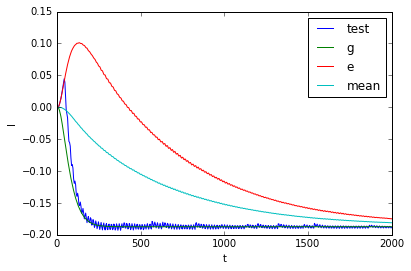

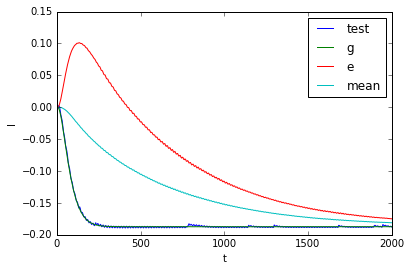

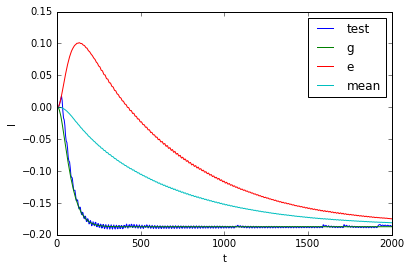

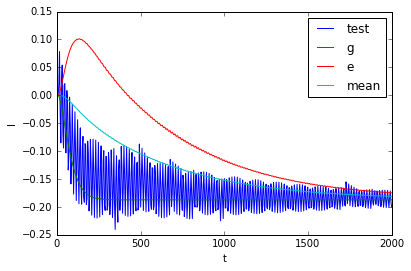

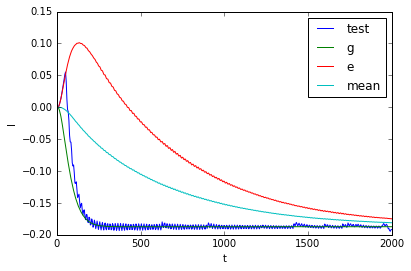

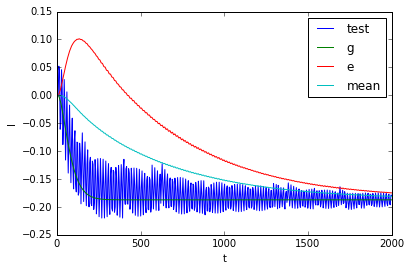

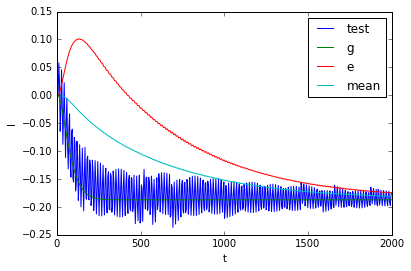

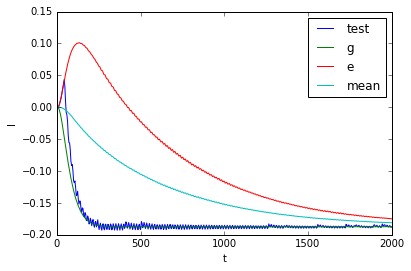

In [21]:
args ={}
args['wc'] = wc
if RFT:
    Isignal = "0.01*tanh(t/10.)"
else:
    Isignal = "0.01*tanh(t/10.)*cos(wc*t)"
H = [H0, [HI, Isignal]]
errors = 0
#exps = np.exp(-time_list)
len_tfinal = steps/20
for ii in range (100):
    e_test_output = mcsolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=1, options=Options(nsteps=15), args = args, progress_bar = False)
    Ie_test = e_test_output.expect[0]
    Qe_test = e_test_output.expect[1]
    
    if not RFT:
        Ie_test, Qe_test = Rotate (Ie_test, Qe_test, wc*time_list)
    
    #decision = np.sum((Ie_test[0:len_tfinal] - Imid[0:len_tfinal])) + np.sum((Qe_test[0:len_tfinal] - Qmid[0:len_tfinal]))
    decision = np.sum((Ie_test[0:len_tfinal] - Imid[0:len_tfinal])*Idiff[0:len_tfinal]) + np.sum((Qe_test[0:len_tfinal] - Qmid[0:len_tfinal])*Qdiff[0:len_tfinal])
    #decision = np.sum((Ie_test - Imid)*exps*Idiff) + np.sum((Qe_test - Qmid)*Qdiff*exps)
    if decision < 0:
        errors +=1
        figure()
        plot (time_list,Ie_test, label ="test")
        plot (time_list,Ig, label = "g")
        plot (time_list,Ie, label = "e")

        plot (time_list,Imid, label = "mean")

        ylabel ("I")
        xlabel("t")
        legend()

print (errors)
            
    
    
    